<class 'shapely.geometry.multipolygon.MultiPolygon'>
path found from backward


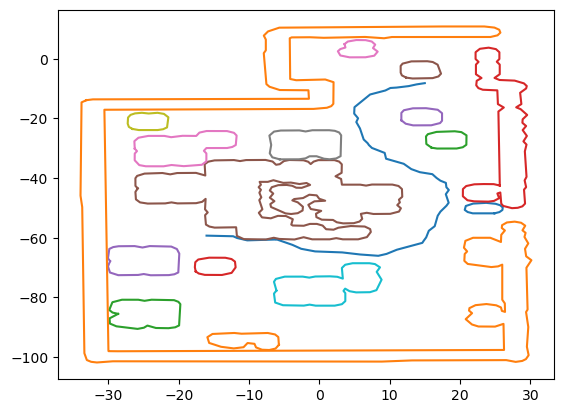

In [2]:
import shapely
import shapely.ops
import numpy as np
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import shape
from SST import SST
import time
from threading import Thread



def get_global_map():

    global_map_list = []
    schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
    }

    with fiona.open("extended_polygon.shp") as shapefile:
        for record in shapefile:
            geometry = shape(record['geometry'])

            # if shapely.contains(geometry,shapely.Point(-28,-58)):
            #     continue
            global_map_list.append(geometry)
            # x5,y5 = geometry.exterior.xy
            # xi2,yi2 = geometry.interiors[0].xy
        map_shapely = shapely.unary_union(global_map_list)

        # print(type(map_shapely))
        
    
    # map_polygon = shapely.Polygon()
    return map_shapely

def get_sst_data(start_point,end_point):
    wheel_base = 1.7
    v_range = [0.5,2.5]
    delta_range = [-28/180*np.pi,28/180*np.pi]
    max_running_time = 60.0
    min_running_time = 2
    bi_tree = True
    time_steps_range = [5,20]


    # create a RRT star search tree
    if shapely.contains(global_map,end_point) or shapely.contains(global_map,start_point):
        print("Invalid start or end position!")
    else:
        sst_path = SST(start_point,end_point,global_map,
                            wheel_base,
                            v_range,delta_range,
                            max_running_time,min_running_time,
                            bi_tree=bi_tree,time_steps_range=time_steps_range)
    
    get_reached = sst_path.get_tree_reached()

    current_time = time.time()
    find_solution = False
    final_path = None

    if bi_tree:
        if get_reached[0]:
            final_path = sst_path.get_forward_final_trajectory()
        elif get_reached[1]:
            final_path = sst_path.get_backward_final_trajectory()
        else:
            print("no path returned")
    else:
        if get_reached:
            final_path = sst_path.get_forward_final_trajectory()
        else:
            print("no path returned")

    # f_node_list = sst_path.get_forward_tree_node_list()
    # if bi_tree:
    #     b_node_list = sst_path.get_backward_tree_node_list()
    
    return final_path

    

if __name__ == "__main__":
    global_map = get_global_map()
    print(type(global_map))

    # get the start and end position
    start_point = shapely.Point(14.9791,-8.1520,3.1)

    end_point = shapely.Point(-16.0463,-59.2992,3.1)

    # wheel_base = 1.5
    # v_range = [1.0,2.5]
    # delta_range = [-25/180*np.pi,25/180*np.pi]
    # max_running_time = 60.0
    # min_running_time = 2
    bi_tree = True
    # time_steps_range = [3,20]


    # # create a RRT star search tree
    # if shapely.contains(global_map,end_point) or shapely.contains(global_map,start_point):
    #     print("Invalid start or end position!")
    # else:
    #     sst_path = SST(start_point,end_point,global_map,
    #                         wheel_base,
    #                         v_range,delta_range,
    #                         max_running_time,min_running_time,
    #                         bi_tree=bi_tree,time_steps_range=time_steps_range)

    # get_reached = sst_path.get_tree_reached()

    # current_time = time.time()
    # find_solution = False
    final_path = True

    final_path = get_sst_data(start_point,end_point)

    # while time.time()-current_time>min_running_time and time.time()-current_time<max_running_time and not find_solution:
    #     print("keep running planner")
    #     sst_path.get_forward_tree()
    #     # Thread(target=sst_path.get_forward_child_state).start()
    #     # Thread(target=sst_path.get_backward_child_state).start()
    
    # if bi_tree:
    #     if get_reached[0]:
    #         final_path = sst_path.get_forward_final_trajectory()
    #     elif get_reached[1]:
    #         final_path = sst_path.get_backward_final_trajectory()
    #     else:
    #         print("no path returned")
    # else:
    #     if get_reached:
    #         final_path = sst_path.get_forward_final_trajectory()
    #     else:
    #         print("no path returned")

    # f_node_list = sst_path.get_forward_tree_node_list()
    # if bi_tree:
    #     b_node_list = sst_path.get_backward_tree_node_list()

    # save the trajectory data to file

    if not final_path is None:

        # s_file = open("/home/acsr/Documents/SST_data.txt","w")
        s_file = open("SST_data.txt","w")


        for n in final_path:
            s_file.write(str(n.x))
            s_file.write(",")
            s_file.write(str(n.y))
            s_file.write(",")
            s_file.write(str(n.z))
            s_file.write("\n")

        s_file.close()

    if not final_path is None:
        x_r = []
        y_r = []
        for n in final_path:
            x_r.append(n.x)
            y_r.append(n.y)
        # plt.scatter(x_r,y_r,marker=",")
        plt.plot(x_r,y_r)
        
    for n in global_map.geoms:
        x,y = n.exterior.xy
        plt.plot(x,y)
    
    

    
    
    
    x_n = []
    y_n = []
    x_b = []
    y_b = []
    # for n in f_node_list:
        

    #     x_n.append(n.pose.x)
    #     y_n.append(n.pose.y)
    # plt.scatter(x_n,y_n,marker="1")
    # if bi_tree:
    #     for n in b_node_list:
        
    #         print(n.pose.x,n.pose.y)
    #         x_b.append(n.pose.x)
    #         y_b.append(n.pose.y)
        # plt.scatter(x_b,y_b,marker="2")
    plt.show()